# Scratchpad for paper revisions

In [2]:
%load_ext autoreload
%autoreload 2
import pickle
import os, sys
root_path = os.path.realpath('../')
sys.path.append(root_path)

import torch
from pathlib import Path
import numpy as np
import random


from utils.data import make_blobs_dataset, make_trees_dataset
from utils.nnet import get_device

from hebbcl.logger import LoggerFactory
from hebbcl.model import Nnet, ScaledNet2Hidden
from hebbcl.trainer import Optimiser, train_on_blobs, train_on_trees
from hebbcl.parameters import parser
from hebbcl.tuner import HPOTuner

## Hyperparameter optimisation
hpo on network trained with fewer episodes

### HPO: blocked trials with oja_ctx

In [ ]:
# HPO on blocked trials with oja_ctx
args = parser.parse_args(args=[])
args.n_episodes = 8
args.hpo_fixedseed = True
args.hpo_scheduler = "bohb"
args.hpo_searcher = "bohb"
# dict(sorted(vars(args).items(),key=lambda k: k[0]))
args.ctx_avg = False
# init tuner
tuner = HPOTuner(args, time_budget=60*15, metric="loss")

tuner.tune(n_samples=500)

df = tuner.results
df = df[["mean_loss", "mean_acc", "config.lrate_sgd","config.lrate_hebb", "config.ctx_scaling","config.seed","done"]]
df = df[df["done"]==True]
df = df.drop(columns=["done"])
df = df.dropna()
df = df.sort_values("mean_loss",ascending=True)

df.reset_index()
print(df.head(15))

print(tuner.best_cfg)

with open("../results/raytune_oja_ctx_blocked_8episodes.pkl", "wb") as f:
    pickle.dump(df, f)

In [ ]:
with open("../results/raytune_oja_ctx_blocked_8episodes.pkl", "rb") as f:
    df = pickle.load(f)

df.iloc[0]

In [ ]:
# verify results 
with open("../results/raytune_oja_ctx_blocked_8episodes.pkl", "rb") as f:
    df = pickle.load(f)
# obtain params
args = parser.parse_args(args=[])

# set checkpoint directory
save_dir = (
        Path("checkpoints") / "test_allhebb"
    ) 

# get device (gpu/cpu)
args.device = get_device(args.cuda)[0]

# override defaults 
args.n_episodes = 8
args.lrate_hebb = df.iloc[0]["config.lrate_hebb"]
args.lrate_sgd = df.iloc[0]["config.lrate_sgd"]
args.ctx_scaling = df.iloc[0]["config.ctx_scaling"]
args.ctx_avg = False
np.random.seed(int(df.iloc[0]["config.seed"]))
random.seed(int(df.iloc[0]["config.seed"]))
torch.manual_seed(int(df.iloc[0]["config.seed"]))


# create dataset 
dataset = make_blobs_dataset(args)

# instantiate logger, model and optimiser:
logger = LoggerFactory.create(args, save_dir)
model = Nnet(args)
optimiser = Optimiser(args)

# send model to device (GPU?)
model = model.to(args.device)


# train model
train_on_blobs(args, model, optimiser, dataset, logger)

print(f"config: lrate_sgd: {args.lrate_sgd:.4f}, lrate_hebb: {args.lrate_hebb:.4f}, context offset: {args.ctx_scaling}")
print(f"terminal accuracy: {logger.results['acc_total'][-1]:.2f}, loss: {logger.results['losses_total'][-1]:.2f}")

### HPO: Interleaved trials

In [ ]:
# HPO on blocked trials with oja_ctx
args = parser.parse_args(args=[])
args.n_episodes = 8
args.hpo_fixedseed = True
args.hpo_scheduler = "bohb"
args.hpo_searcher = "bohb"
args.training_schedule = "interleaved"
# dict(sorted(vars(args).items(),key=lambda k: k[0]))
args.ctx_avg = False
# init tuner
tuner = HPOTuner(args, time_budget=60*15, metric="loss")

tuner.tune(n_samples=500)

df = tuner.results
df = df[["mean_loss", "mean_acc", "config.lrate_sgd","config.lrate_hebb", "config.ctx_scaling","config.seed","done"]]
df = df[df["done"]==True]
df = df.drop(columns=["done"])
df = df.dropna()
df = df.sort_values("mean_loss",ascending=True)

df.reset_index()
print(df.head(15))

print(tuner.best_cfg)

with open("../results/raytune_oja_ctx_interleaved_8episodes.pkl", "wb") as f:
    pickle.dump(df, f)

In [ ]:
# verify results 

# obtain params
args = parser.parse_args(args=[])

# set checkpoint directory
save_dir = (
        Path("checkpoints") / "test_allhebb"
    ) 

# get device (gpu/cpu)
args.device = get_device(args.cuda)[0]

# override defaults 
args.n_episodes = 8
args.lrate_hebb = df.iloc[0]["config.lrate_hebb"]
args.lrate_sgd = df.iloc[0]["config.lrate_sgd"]
args.ctx_scaling = df.iloc[0]["config.ctx_scaling"]
args.ctx_avg = False
args.training_schedule = "interleaved"
np.random.seed(int(df.iloc[0]["config.seed"]))
random.seed(int(df.iloc[0]["config.seed"]))
torch.manual_seed(int(df.iloc[0]["config.seed"]))



# create dataset 
dataset = make_blobs_dataset(args)

# instantiate logger, model and optimiser:
logger = LoggerFactory.create(args, save_dir)
model = Nnet(args)
optimiser = Optimiser(args)

# send model to device (GPU?)
model = model.to(args.device)


# train model
train_on_blobs(args, model, optimiser, dataset, logger)

print(f"config: lrate_sgd: {args.lrate_sgd:.4f}, lrate_hebb: {args.lrate_hebb:.4f}, context offset: {args.ctx_scaling}")
print(f"terminal accuracy: {logger.results['acc_total'][-1]:.2f}, loss: {logger.results['losses_total'][-1]:.2f}")

### HPO: all_oja

In [113]:
with open("../results/raytune_trees_asha_interleaved_ojaall_1ctx.pkl","rb") as f:
    df = pickle.load(f)["df"]
df = df.sort_values("mean_acc",ascending=False).head(15)
df

,mean_loss,mean_acc,done,config.lrate_sgd,config.lrate_hebb,config.ctx_scaling,config.seed
trial_id,,,,,,,
dd895_02286,-7244.266113,0.9825,True,0.003509,0.000137,3,8102
dd895_01058,-7132.384277,0.9825,True,0.000845,0.000225,3,802
dd895_00485,-7290.099609,0.9800,True,0.003067,0.000120,5,4620
dd895_02205,-7279.646484,0.9775,True,0.001809,0.000104,3,2612
dd895_02063,-7140.266113,0.9725,True,0.000774,0.000134,5,9754
dd895_02154,-7094.134766,0.9700,True,0.000993,0.000187,3,5437
dd895_00377,-7031.128906,0.9625,True,0.003907,0.000170,5,9768
dd895_00689,-6842.807617,0.9550,True,0.001442,0.000181,3,9170
dd895_00642,-6931.358887,0.9550,True,0.000973,0.000113,5,894


In [116]:
# verify results 

# obtain params
args = parser.parse_args(args=[])

# set checkpoint directory
save_dir = (
        Path("checkpoints") / "test_allhebb"
    ) 

# get device (gpu/cpu)
args.device = get_device(args.cuda)[0]

# override defaults 
args.n_episodes = 200
args.n_layers = 2
args.n_features = 974
args.lrate_hebb = df.iloc[0]["config.lrate_hebb"]
args.lrate_sgd = df.iloc[0]["config.lrate_sgd"]
args.ctx_scaling = df.iloc[0]["config.ctx_scaling"]
args.ctx_avg = False
args.training_schedule = "interleaved"
np.random.seed(int(df.iloc[0]["config.seed"]))
random.seed(int(df.iloc[0]["config.seed"]))
torch.manual_seed(int(df.iloc[0]["config.seed"]))



# create dataset 
dataset = make_trees_dataset(args)

# instantiate logger, model and optimiser:
logger = LoggerFactory.create(args, save_dir)
model = ScaledNet2Hidden(args)
optimiser = Optimiser(args)

# send model to device (GPU?)
model = model.to(args.device)


# train model
train_on_trees(args, model, optimiser, dataset, logger)

print(f"config: lrate_sgd: {args.lrate_sgd:.4f}, lrate_hebb: {args.lrate_hebb:.4f}, context offset: {args.ctx_scaling}")
print(f"terminal accuracy: {logger.results['acc_total'][-1]:.2f}, loss: {logger.results['losses_total'][-1]:.2f}")

5000
step 0, loss: task a -0.4216, task b 0.3495 | acc: task a 0.5000, task b 0.5000
...1st hidden: n_a: 5 n_b: 4
... 2nd hidden: n_a: 7 n_b: 7
step 50, loss: task a 0.1933, task b -1.9896 | acc: task a 0.5000, task b 0.5000
...1st hidden: n_a: 8 n_b: 6
... 2nd hidden: n_a: 1 n_b: 9
step 100, loss: task a -1.1461, task b -12.2039 | acc: task a 0.5000, task b 0.5000
...1st hidden: n_a: 6 n_b: 7
... 2nd hidden: n_a: 2 n_b: 3
step 150, loss: task a -7.9329, task b -36.3379 | acc: task a 0.5000, task b 0.5000
...1st hidden: n_a: 3 n_b: 2
... 2nd hidden: n_a: 1 n_b: 2
step 200, loss: task a -8.0407, task b -44.7073 | acc: task a 0.5000, task b 0.5000
...1st hidden: n_a: 3 n_b: 2
... 2nd hidden: n_a: 1 n_b: 1
step 250, loss: task a -34.5834, task b -113.7178 | acc: task a 0.5000, task b 0.5000
...1st hidden: n_a: 1 n_b: 3
... 2nd hidden: n_a: 1 n_b: 0
step 300, loss: task a -122.8599, task b -120.6186 | acc: task a 0.5000, task b 0.5000
...1st hidden: n_a: 1 n_b: 3
... 2nd hidden: n_a: 1 n_b

In [5]:
# test tune validator

from hebbcl.tuner import validate_tuner_results

validate_tuner_results(filename="trees_asha_interleaved_vanilla_1ctx", 
filepath="../results/",datapath="../datasets/",datasuffix="_ds18")

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.0min


In [5]:
from utils.data import resize_images
for c in ["training", "test"]:
    for g in ["north", "south"]:
        resize_images(c+"_data_"+g +"_withgarden", size=[24,24])

In [7]:
args = parser.parse_args(args=[])
args.n_features = 24*24*3+2
args.n_layers = 2
data = make_trees_dataset(args,filesuffix="_withgarden_ds24")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


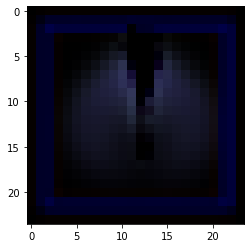

In [13]:
import matplotlib.pyplot as plt
plt.imshow(data["x_test_a"][0,:-2].reshape((24,24,3)))